📊 평균 요약표
                   모델  페르소나  사실성  적합성  일관성   총점
0  Base (gpt-4o-mini)   bus  1.0  1.1  1.0  3.1
1  Base (gpt-4o-mini)   pet  1.0  1.0  2.0  4.0
2  Base (gpt-4o-mini)  trip  1.0  1.0  1.6  3.6
3       RAG (카드DB 기반)   bus  3.0  3.0  3.0  9.0
4       RAG (카드DB 기반)   pet  3.0  3.0  3.0  9.0
5       RAG (카드DB 기반)  trip  3.0  2.0  3.0  8.0


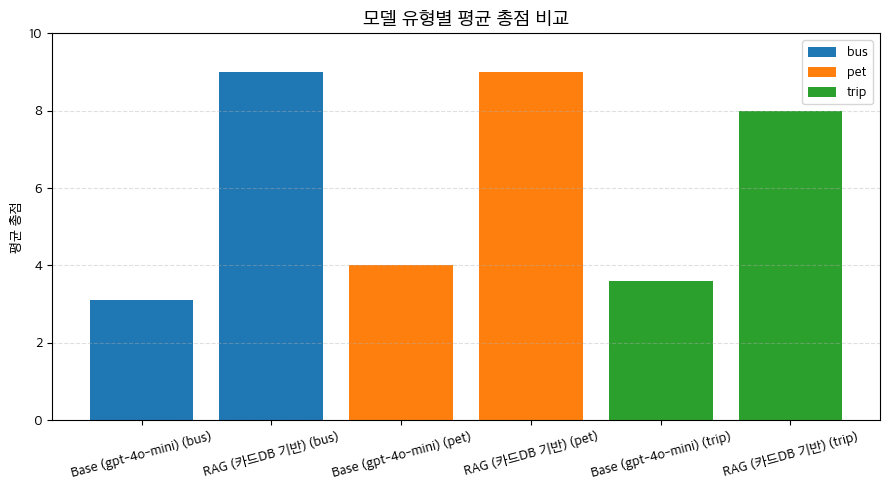

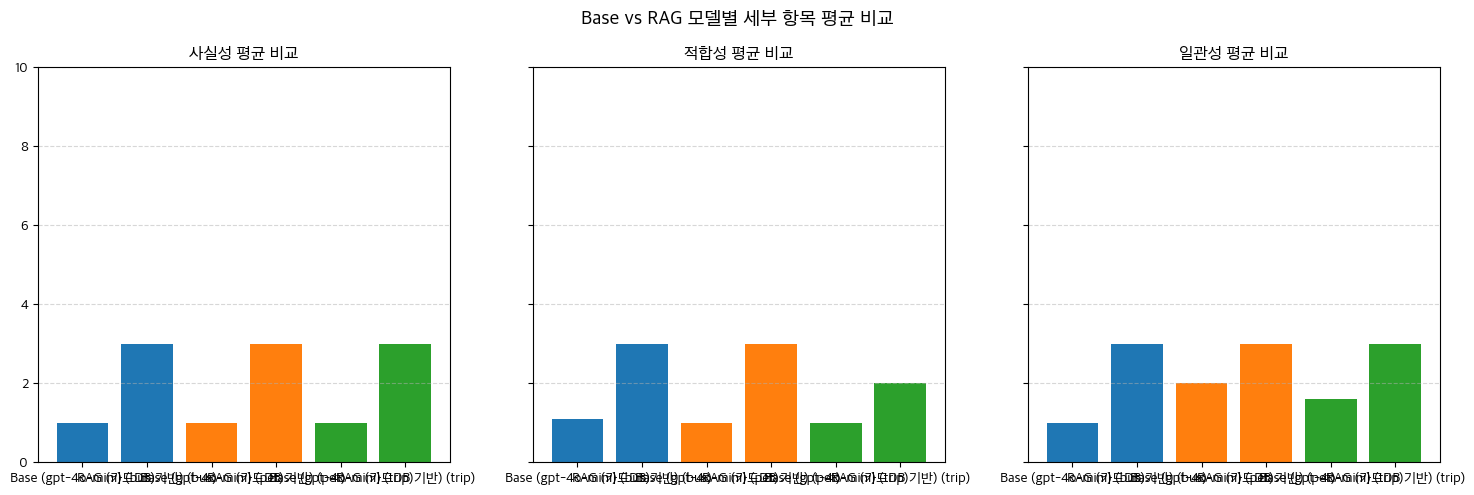

/var/folders/dd/f1qp1gxx5m910qvm9jz_3hp80000gn/T/ipykernel_8520/1328099318.py:119: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) Apple SD Gothic Neo.
  plt.tight_layout()
/var/folders/dd/f1qp1gxx5m910qvm9jz_3hp80000gn/T/ipykernel_8520/1328099318.py:119: UserWarning: Glyph 9878 (\N{SCALES}) missing from font(s) Apple SD Gothic Neo.
  plt.tight_layout()
/var/folders/dd/f1qp1gxx5m910qvm9jz_3hp80000gn/T/ipykernel_8520/1328099318.py:119: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Apple SD Gothic Neo.
  plt.tight_layout()
/var/folders/dd/f1qp1gxx5m910qvm9jz_3hp80000gn/T/ipykernel_8520/1328099318.py:119: UserWarning: Glyph 128078 (\N{THUMBS DOWN SIGN}) missing from font(s) Apple SD Gothic Neo.
  plt.tight_layout()
/opt/homebrew/anaconda3/envs/sesac-env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) Apple SD Gothic Neo.
  fig.canvas.print_figure(bytes_io, *

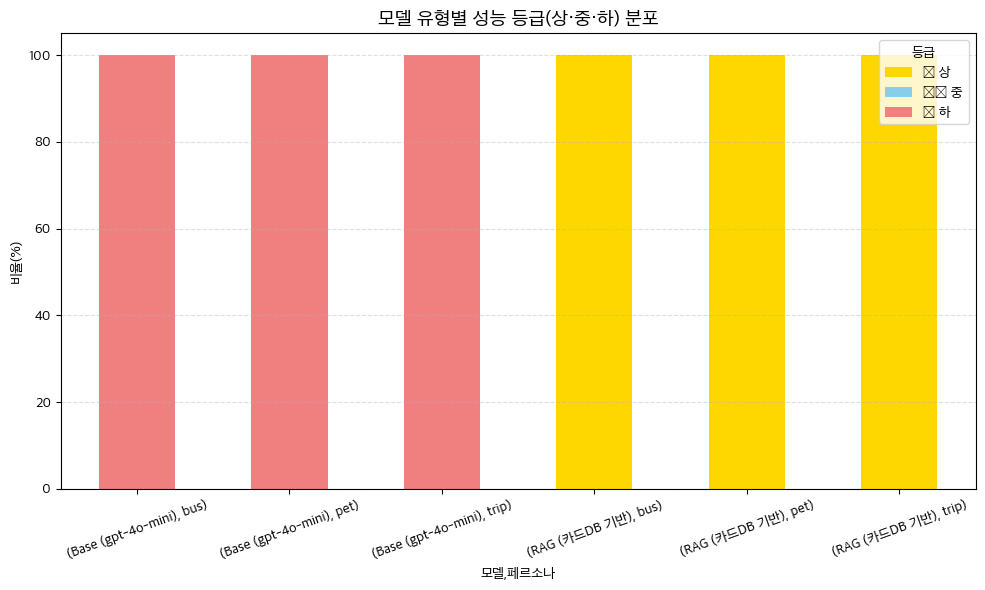

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# -----------------------------
# 1️⃣ 한글 폰트 설정
# -----------------------------
plt.rcParams['axes.unicode_minus'] = False
font_path = '/System/Library/Fonts/AppleSDGothicNeo.ttc'  # macOS
rc('font', family=font_manager.FontProperties(fname=font_path).get_name())

# -----------------------------
# 2️⃣ 데이터 불러오기
# -----------------------------
trip_df = pd.read_csv("model_comparison_results_trip.csv", encoding="utf-8-sig")
pet_df = pd.read_csv("model_comparison_results_pet.csv", encoding="utf-8-sig")

try:
    bus_df = pd.read_csv("model_comparison_results_bus.csv", encoding="utf-8-sig")
    bus_df["페르소나"] = "bus"
except FileNotFoundError:
    print("⚠️ bus 데이터 파일이 아직 없습니다. (건너뜀)")
    bus_df = pd.DataFrame()

trip_df["페르소나"] = "trip"
pet_df["페르소나"] = "pet"

df = pd.concat([trip_df, pet_df, bus_df], ignore_index=True)

# -----------------------------
# 3️⃣ 등급 분류 함수
# -----------------------------
def classify_score(score):
    if score >= 8:
        return "⭐ 상"
    elif 5 <= score < 8:
        return "⚖️ 중"
    elif 3 <= score < 5:
        return "👎 하"
    else:
        return "❓ 기타"

df["성능등급"] = df["총점"].apply(classify_score)

# -----------------------------
# 4️⃣ 평균 통계 요약
# -----------------------------
summary = (
    df.groupby(["모델", "페르소나"])
    [["사실성", "적합성", "일관성", "총점"]]
    .mean()
    .round(2)
    .reset_index()
)

print("📊 평균 요약표")
print(summary)

# -----------------------------
# 5️⃣ 총점 평균 비교 그래프
# -----------------------------
plt.figure(figsize=(9, 5))
for persona in summary["페르소나"].unique():
    persona_data = summary[summary["페르소나"] == persona]
    plt.bar(persona_data["모델"] + " (" + persona + ")", persona_data["총점"], label=persona)

plt.title("모델 유형별 평균 총점 비교", fontsize=14)
plt.ylabel("평균 총점")
plt.xticks(rotation=15)
plt.ylim(0, 10)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# 6️⃣ 세부 항목별 비교
# -----------------------------
metrics = ["사실성", "적합성", "일관성"]
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for i, metric in enumerate(metrics):
    for persona in summary["페르소나"].unique():
        persona_data = summary[summary["페르소나"] == persona]
        axes[i].bar(persona_data["모델"] + " (" + persona + ")", persona_data[metric], label=persona)
    axes[i].set_title(f"{metric} 평균 비교")
    axes[i].set_ylim(0, 10)
    axes[i].grid(axis='y', linestyle='--', alpha=0.5)

plt.suptitle("Base vs RAG 모델별 세부 항목 평균 비교", fontsize=14)
plt.tight_layout()
plt.show()

# -----------------------------
# 7️⃣ 성능 등급(상·중·하) 분포 시각화
# -----------------------------
grade_ratio = (
    df.groupby(["모델", "페르소나", "성능등급"])
    .size()
    .reset_index(name="개수")
)

# ✅ apply → transform 으로 변경 (인덱스 문제 해결)
grade_ratio["비율(%)"] = grade_ratio.groupby(["모델", "페르소나"])["개수"].transform(
    lambda x: round(100 * x / x.sum(), 1)
)

# 스택형 바 차트용 피벗
pivot = grade_ratio.pivot_table(index=["모델", "페르소나"], columns="성능등급", values="비율(%)", fill_value=0)
pivot = pivot.reindex(columns=["⭐ 상", "⚖️ 중", "👎 하"], fill_value=0)

pivot.plot(kind="bar", stacked=True, figsize=(10, 6), color=["gold", "skyblue", "lightcoral"])

plt.title("모델 유형별 성능 등급(상·중·하) 분포", fontsize=14)
plt.ylabel("비율(%)")
plt.xticks(rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.legend(title="등급")
plt.tight_layout()
plt.show()
